In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
matplotlib.rcParams['font.family'] = 'Arial'

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots

init_notebook_mode(connected=True)

import collections
import itertools

import scipy.stats as stats
from scipy.stats import norm
from scipy.special import boxcox1p

import statsmodels
import statsmodels.api as sm

from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.utils import resample

import eli5
import lime
import lime.lime_tabular
import shap
shap.initjs()

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
Combined_data = pd.read_csv('./AB_NYC_2019.csv')
Combined_data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [6]:
Combined_data.shape

(48895, 16)

In [7]:
Combined_data.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [8]:
# 转换日期格式 infer_datetime_format：根据第一个非NaN元素推断日期时间字符串的格式
Combined_data['last_review'] = pd.to_datetime(Combined_data['last_review'], infer_datetime_format=True)

In [9]:
Combined_data['last_review'].head()

0   2018-10-19
1   2019-05-21
2          NaT
3   2019-07-05
4   2018-11-19
Name: last_review, dtype: datetime64[ns]

In [11]:
Combined_data.dtypes

id                                         int64
name                                      object
host_id                                    int64
host_name                                 object
neighbourhood_group                       object
neighbourhood                             object
latitude                                 float64
longitude                                float64
room_type                                 object
price                                      int64
minimum_nights                             int64
number_of_reviews                          int64
last_review                       datetime64[ns]
reviews_per_month                        float64
calculated_host_listings_count             int64
availability_365                           int64
dtype: object

# 1.Preprocessing and EDA
## 1.0 Missing data
处理每一列缺失值

In [19]:
# 统计每一列缺失值总数，按降序排列
total = Combined_data.isnull().sum().sort_values(ascending=False)
# 统计缺失值占比 Combined_data.isnull().count():不为空值的数量/行数
percent = (Combined_data.isnull().sum()) / Combined_data.isnull().count().sort_values(ascending=True)
# 统计缺失值数量及占比
# concat:数据拼接 axis：0表示水平连接，1表示垂直连接
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'], sort=False).sort_values('Total', ascending=False)
missing_data.head(20)

,Total,Percent
reviews_per_month,10052,0.205583
last_review,10052,0.205583
host_name,21,0.000429
name,16,0.000327
availability_365,0,0.000000
calculated_host_listings_count,0,0.000000
number_of_reviews,0,0.000000
minimum_nights,0,0.000000
price,0,0.000000
room_type,0,0.000000


In [20]:
# 删除无用特征 inplace=True：不创建新的对象
Combined_data.drop(['host_name', 'name'], axis=1, inplace=True)

In [21]:
# 评论数为0的数量
Combined_data[Combined_data['number_of_reviews'] == 0.0].shape

(10052, 14)

In [22]:
# 将reviews_per_month空值填充为0
Combined_data['reviews_per_month'] = Combined_data['reviews_per_month'].fillna(0)

In [24]:
# 将last_review空值填充为最小的时间
earliest = min(Combined_data['last_review']) # 2011-03-28 00:00:00
Combined_data['last_review'] = Combined_data['last_review'].fillna(earliest)
# toordinal:该日期在公历中的序数
Combined_data['last_review'] = Combined_data['last_review'].apply(lambda x:x.toordinal() - earliest.toordinal())

In [25]:
# 统计每一列缺失值总数，按降序排列
total = Combined_data.isnull().sum().sort_values(ascending=False)
# 统计缺失值占比 Combined_data.isnull().count():不为空值的数量/行数
percent = (Combined_data.isnull().sum()) / Combined_data.isnull().count().sort_values(ascending=True)
# 统计缺失值数量及占比
# concat:数据拼接 axis：0表示水平连接，1表示垂直连接
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'], sort=False).sort_values('Total', ascending=False)
missing_data.head(20)

,Total,Percent
availability_365,0,0.0
calculated_host_listings_count,0,0.0
reviews_per_month,0,0.0
last_review,0,0.0
number_of_reviews,0,0.0
minimum_nights,0,0.0
price,0,0.0
room_type,0,0.0
longitude,0,0.0
latitude,0,0.0


## 1.2 选择预测目标（智能价格回归器）
AirBNB的机器学习模型之一是智能定价。 在客户输入租房信息后，AirBNB会给出一个合适的价格。 本笔记本的目的是建立和训练这个数据集的智能定价模型。  
## 1.3 价格分布
注意到目标有一个高度倾斜的分布。 这可能会给线性回归等机器学习算法带来问题。 对数变换和异常值的去除使分布看起来更接近正态分布。  

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


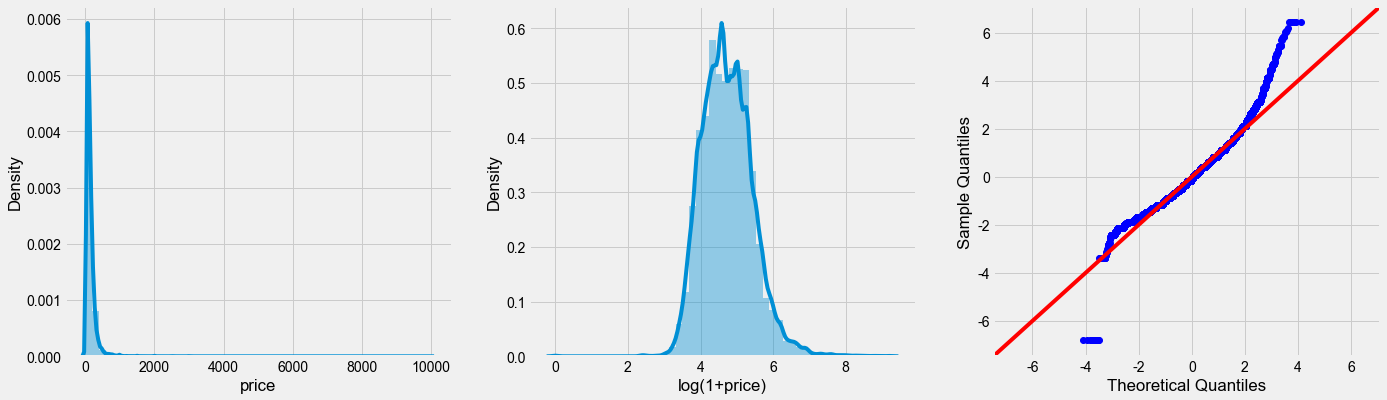

In [33]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
# 画第一张价格图
sns.distplot(Combined_data['price'], ax=axes[0])
# 画第二张图，log1p：使数据平滑化
sns.distplot(np.log1p(Combined_data['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')
# 画第三张图
sm.qqplot(np.log1p(Combined_data['price']), stats.norm, fit=True, line='45', ax=axes[2]);

In [36]:
# 从上面第二张图，进行筛选
Combined_data = Combined_data[np.log1p(Combined_data['price']) < 8]
Combined_data = Combined_data[np.log1p(Combined_data['price']) > 3]

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


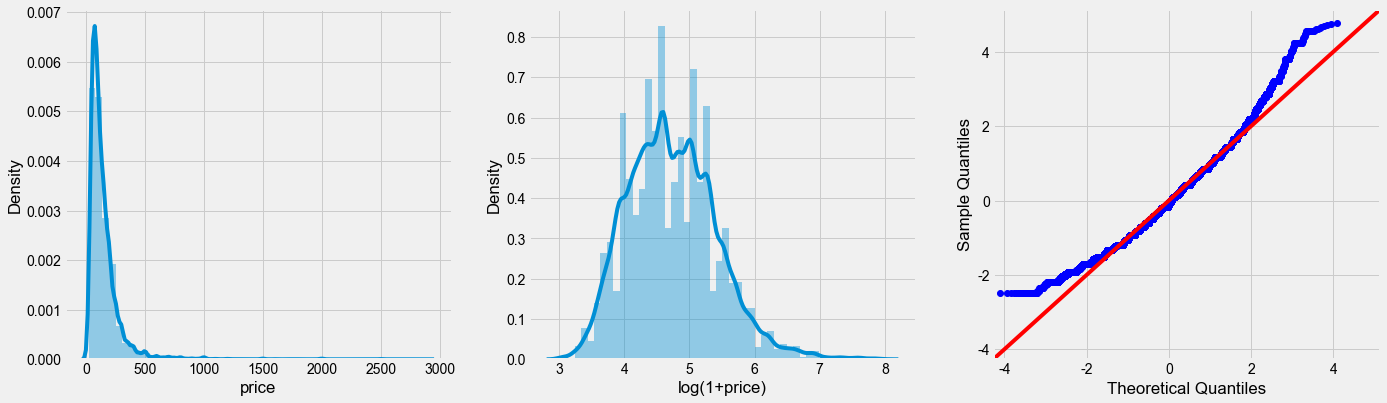

In [37]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
# 画第一张价格图
sns.distplot(Combined_data['price'], ax=axes[0])
# 画第二张图，log1p：使数据平滑化
sns.distplot(np.log1p(Combined_data['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')
# 画第三张图
sm.qqplot(np.log1p(Combined_data['price']), stats.norm, fit=True, line='45', ax=axes[2]);

In [38]:
Combined_data['price'] = np.log1p(Combined_data['price'])

## 1.4 预测分布
### 1.4.1 一组预测因素

In [39]:
Combined_data.columns

Index(['id', 'host_id', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

In [40]:
len(Combined_data['host_id'].unique())

37384

由于唯一房主的数量接近示例的总数量，所以不打算在回归分析中使用房主ID，因为它会导致模型中的参数数量激增!  
 
在现实生活中，当房主上有更多的数据，也许还有一些特性数据时，我希望房主和房产的过去历史可以成为一个强大的价格预测器的预测因素  

In [41]:
# 删除房主ID与name列
Combined_data = Combined_data.drop(['host_id', 'id'], axis=1)

### 1.4.2 Neighbourhood group
我注意到斯塔顿岛和布朗克斯在这个数据集中的代表性非常低。 对于斯塔顿岛来说，原因是岛上的人口很少。 然而，对于人口为140万的布朗克斯区和人口分别为250万和240万的布鲁克林/皇后区来说，情况却并非如此。  
这是有道理的:皇后区、布朗克斯区，在一定程度上还有布鲁克林，都是住宅区，不像曼哈顿既是商业中心又是旅游目的地。  

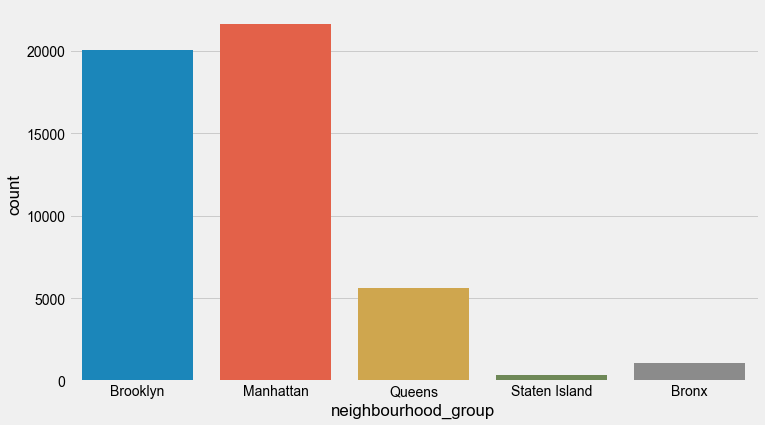

In [42]:
# catplot：分类图
sns.catplot(x='neighbourhood_group', kind='count', data=Combined_data)
# 获得当前图表
fig = plt.gcf()
fig.set_size_inches(12, 6)

### 1.4.3 经纬度
经度和纬度之间有一定的相关性。 这是因为房屋的位置往往是成群的。  

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

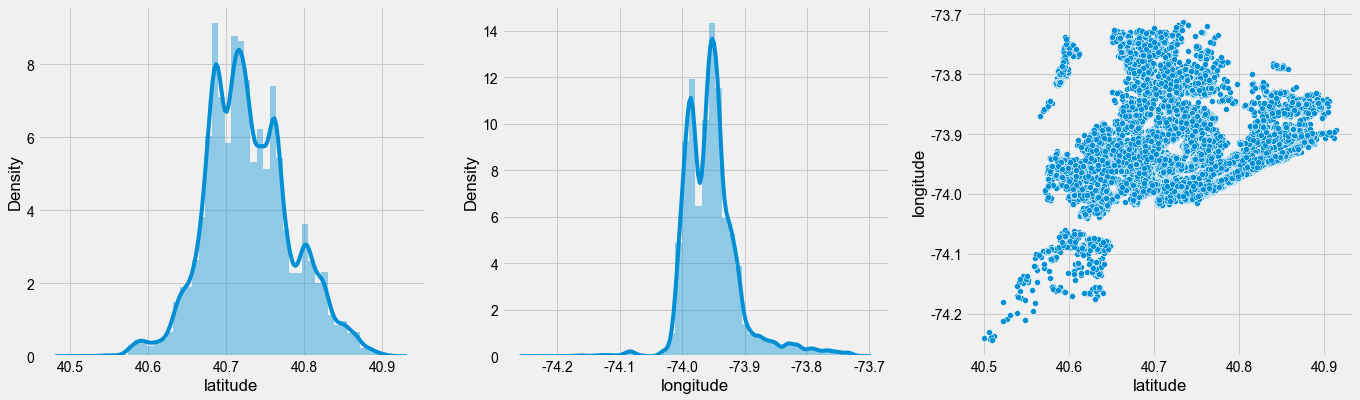

In [45]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
# distplot:直方图
sns.distplot(Combined_data['latitude'], ax=axes[0])
sns.distplot(Combined_data['longitude'], ax=axes[1])
sns.scatterplot(x=Combined_data['latitude'], y=Combined_data['longitude'])

### 1.4.4 房屋类型
至于房间类型，这个数据集与“合租房”属性保持平衡。 私人房间和整个家庭/公寓的出租比例很接近，整个家庭/公寓占私人房间的比例小于10%。  

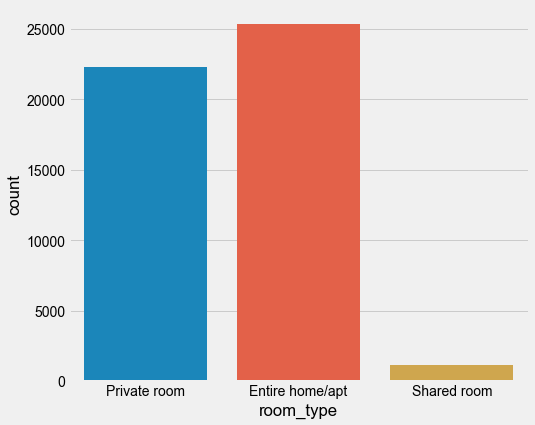

In [46]:
sns.catplot(x='room_type', kind='count', data = Combined_data)
fig = plt.gcf()
fig.set_size_inches(8,6)

Text(0, 0.5, 'count')

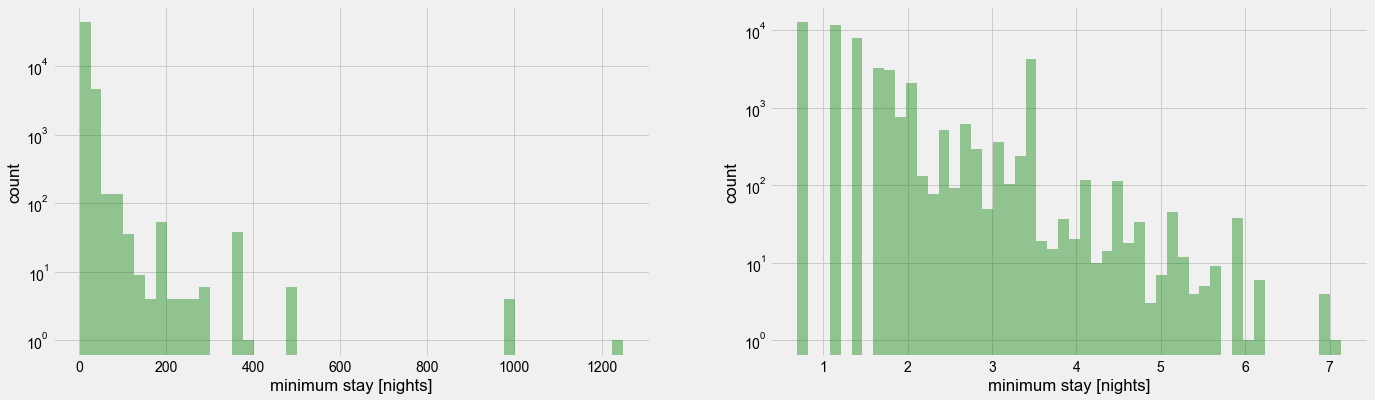

In [48]:
### 1.4.5 出租最小天数
fig, axes = plt.subplots(1,2, figsize=(21,6))
# kde:制核密度估计图 False表示绘制  rug:是否在支撑轴上绘制rugplot()图
sns.distplot(Combined_data['minimum_nights'], rug=False, kde=False, color='green', ax=axes[0])
axes[0].set_yscale('log')
axes[0].set_xlabel('minimum stay [nights]')
axes[0].set_ylabel('count')

sns.distplot(np.log1p(Combined_data['minimum_nights']), rug=False, kde=False, color='green', ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_xlabel('minimum stay [nights]')
axes[1].set_ylabel('count')

In [49]:
Combined_data['minimum_nights'] = np.log1p(Combined_data['minimum_nights'])

### 1.4.6 每月评论数
每个月的评论数量分布是高度倾斜的，无论我们如何削减它。 这是因为在小的数字上有很大的权重:有很多属性得到了很少的评论，还有很多属性得到了很多评论。  
一种解释是，在一年中的大部分时间里，可以买到的房产会得到更多的评价。 然而，reviews_per_month和availability_365变量的散点图显示没有证据表明两者之间存在关系，因此解释似乎是无效的。  

Text(0.5, 0, 'ln(reviews_per_month)')

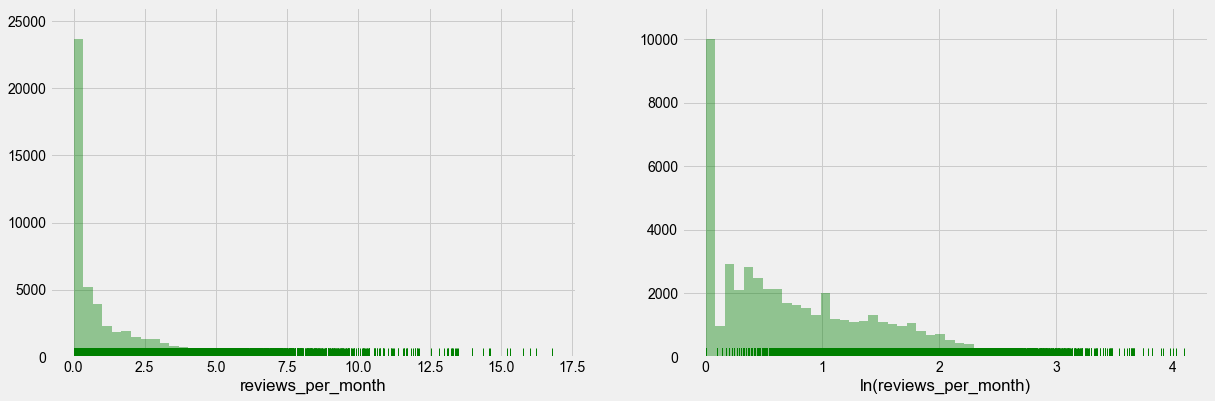

In [55]:
fig, axes=plt.subplots(1,2, figsize=(18.5, 6))

sns.distplot(Combined_data[Combined_data['reviews_per_month']<17.5]['reviews_per_month'], rug=True, kde=False, color='green', ax=axes[0])
sns.distplot(np.sqrt(Combined_data[Combined_data['reviews_per_month']<17.5]['reviews_per_month']), rug=True, kde=False, color='green', ax=axes[1])
axes[1].set_xlabel('ln(reviews_per_month)')

<AxesSubplot:xlabel='availability_365', ylabel='reviews_per_month'>

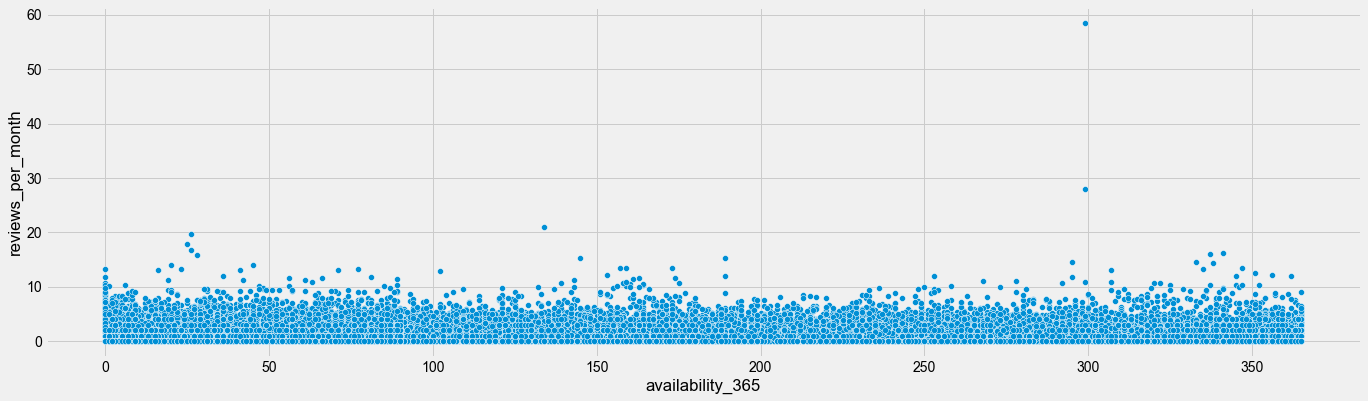

In [57]:
fig, axes = plt.subplots(1,1, figsize=(21,6))
sns.scatterplot(x=Combined_data['availability_365'], y=Combined_data['reviews_per_month'])

In [58]:
Combined_data['reviews_per_month'] = Combined_data[Combined_data['reviews_per_month'] < 17.5]['reviews_per_month']

### Availability_365
这种分布高度偏向低端和高端。 
数据集包含大量的房屋，这些房屋每年只有几天可用，还有相当数量的房屋>可以使用300天。  

(0.0, 365.0)

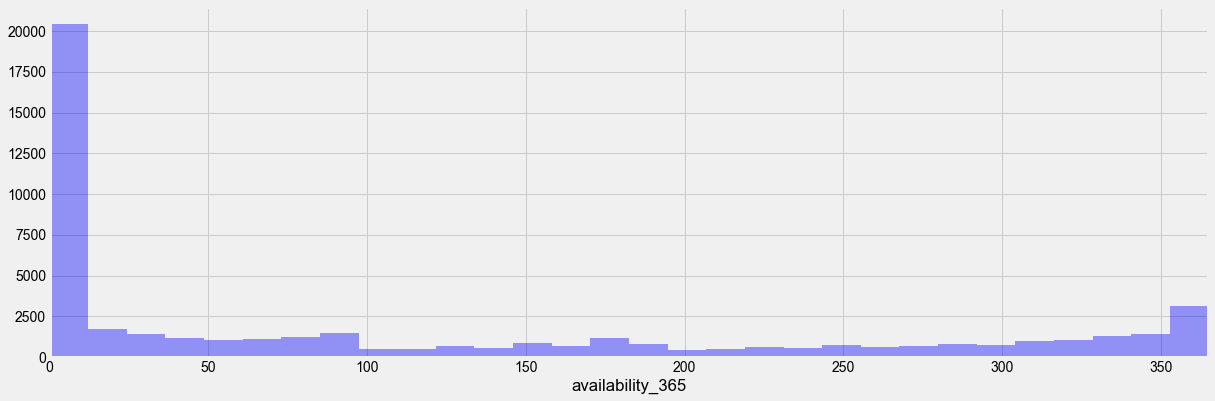

In [59]:
fig, axes = plt.subplots(1,1, figsize=(18.5, 6))
sns.distplot(Combined_data['availability_365'], rug=False, kde=False, color='blue', ax=axes)
axes.set_xlabel('availability_365')
axes.set_xlim(0, 365)

### Feature engineering

In [60]:
Combined_data['all_year_avail'] = Combined_data['availability_365']>353
Combined_data['low_avail'] = Combined_data['availability_365'] < 12
Combined_data['no_reviews'] = Combined_data['reviews_per_month']==0

## 1.5 双变量相关分析
### 1.5.0 pearson 相关系数矩阵
这些变量之间似乎不存在明显、强烈的相关性。  
然而，每月的评论数量(40%)与总评论数量相关，而总评论数量(30%)与该物业的可用性相关。 这两种相关性都有意义。  
有趣的是经度与价格呈反相关(20%)。 这也说得通——布朗克斯和皇后区的房产比曼哈顿和布鲁克林便宜。  

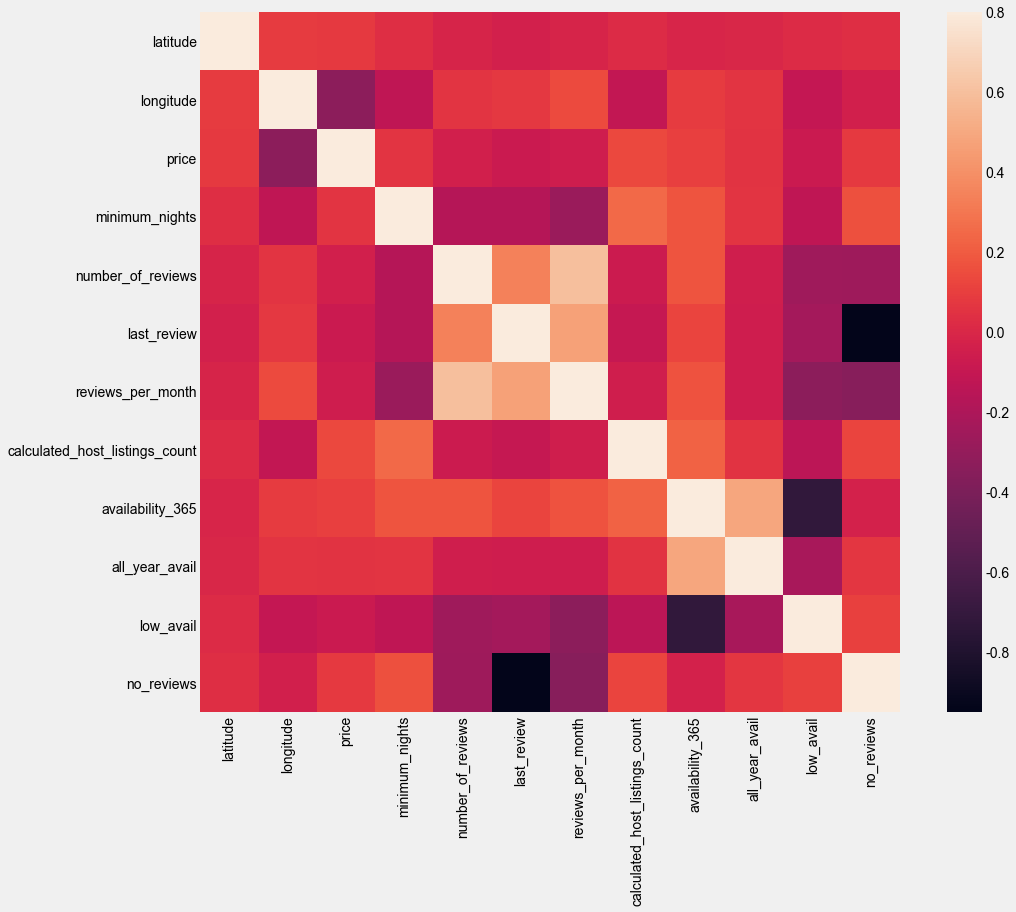

In [61]:
corrmatrix = Combined_data.corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corrmatrix, vmax=0.8, square=True)
sns.set(font_scale=0.8)

## 1.6 编码分类特征

In [62]:
categorical_features = Combined_data.select_dtypes(include=['object'])
categorical_features.shape

(48784, 3)

In [63]:
categorical_feature_one_hot = pd.get_dummies(categorical_features)
categorical_feature_one_hot.head()

,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_Allerton,neighbourhood_Arden Heights,neighbourhood_Arrochar,neighbourhood_Arverne,neighbourhood_Astoria,...,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [64]:
Combined_data['reviews_per_month'] = Combined_data['reviews_per_month'].fillna(0)

In [68]:
## 1.7 保存特征以备未来使用
numerical_features = Combined_data.select_dtypes(exclude=['object'])
y = numerical_features.price
numerical_features = numerical_features.drop(['price'], axis=1)
numerical_features.shape, numerical_features.dtypes

((48784, 11),
 latitude                          float64
 longitude                         float64
 minimum_nights                    float64
 number_of_reviews                   int64
 last_review                         int64
 reviews_per_month                 float64
 calculated_host_listings_count      int64
 availability_365                    int64
 all_year_avail                       bool
 low_avail                            bool
 no_reviews                           bool
 dtype: object)

In [69]:
X = np.concatenate((numerical_features, categorical_feature_one_hot), axis=1)
X_df = pd.concat([numerical_features, categorical_feature_one_hot], axis=1)

In [70]:
Processed_data = pd.concat([X_df, y], axis=1)
Processed_data.to_csv('./NYC_Airbnb_Processed.dat')

In [ ]:
## 1.8 划分训练/测试集
把数据分成测试集和训练集。用数据上的误差作为对模型的无偏估计。  
将训练集进一步分割为训练集和验证集，或者交叉验证。  

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
print('Dimensions of the training feature matrix: {}'.format(X_train.shape))
print('Dimensions of the training target vector: {}'.format(y_train.shape))
print('Dimensions of the test feature matrix: {}'.format(X_test.shape))
print('Dimensions of the test target vector: {}'.format(y_test.shape))

Dimensions of the training feature matrix: (39027, 240)
Dimensions of the training target vector: (39027,)
Dimensions of the test feature matrix: (9757, 240)
Dimensions of the test target vector: (9757,)


### 1.9 重新调节设计矩阵
使用sklearn的RobustScaler()调节设计矩阵，这样每个预测器的均值和单位方差都为零。 这有助于线性回归等机器学习算法的收敛。  
通过定义基于训练数据而不是测试数据的缩放转换来避免数据窥探。

In [75]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# 2. 模型
## 2.0 交叉验证例程
根据5倍的k倍交叉验证给模型打分。  

In [77]:
n_folds = 5

def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=91).get_n_splits(numerical_features)
    return cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

def rmse_lv_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=91).get_n_splits(numerical_features)
    return cross_val_score(model, Xlv_train, y_train, scoring='neg_mean_squared_error', cv=kf)

## 2.1 对基本模型进行评分(无参数调优)

In [80]:
for Model in [LinearRegression, Ridge, Lasso, ElasticNet, RandomForestRegressor, XGBRegressor, HuberRegressor]:
    if Model == XGBRegressor: 
        cv_res = rmse_cv(XGBRegressor(objective='reg:squarederror'))
    else:
        cv_res = rmse_cv(Model())
    print('{}: {:.5f} +/- {:.5f}'.format(Model.__name__, -cv_res.mean(), cv_res.std()))

LinearRegression: 16256147625593.25977 +/- 28652161036745.84375
Ridge: 0.19438 +/- 0.00621
Lasso: 0.45210 +/- 0.00663
ElasticNet: 0.45141 +/- 0.00662
RandomForestRegressor: 0.17706 +/- 0.00557
XGBRegressor: 0.17485 +/- 0.00495


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


HuberRegressor: 0.20435 +/- 0.00965


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


## 2.2 Ridge Regression
### 2.2.0 超参数优化
通过基于交叉验证分数的伸缩搜索找到L2惩罚超参数的最佳值。 
然后在整个训练集上训练Ridge模型，并测试它在保留的测试集上的表现。  

In [81]:
alphas1 = [0.05, 0.1, 0.3, 1, 3, 5, 10, 30, 50, 75]
cv_ridge1 = [-rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas1]

In [83]:
alphas2 = [0.5*i for i in range(4,12)]
cv_ridge2 = [-rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas2]


The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.

The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.


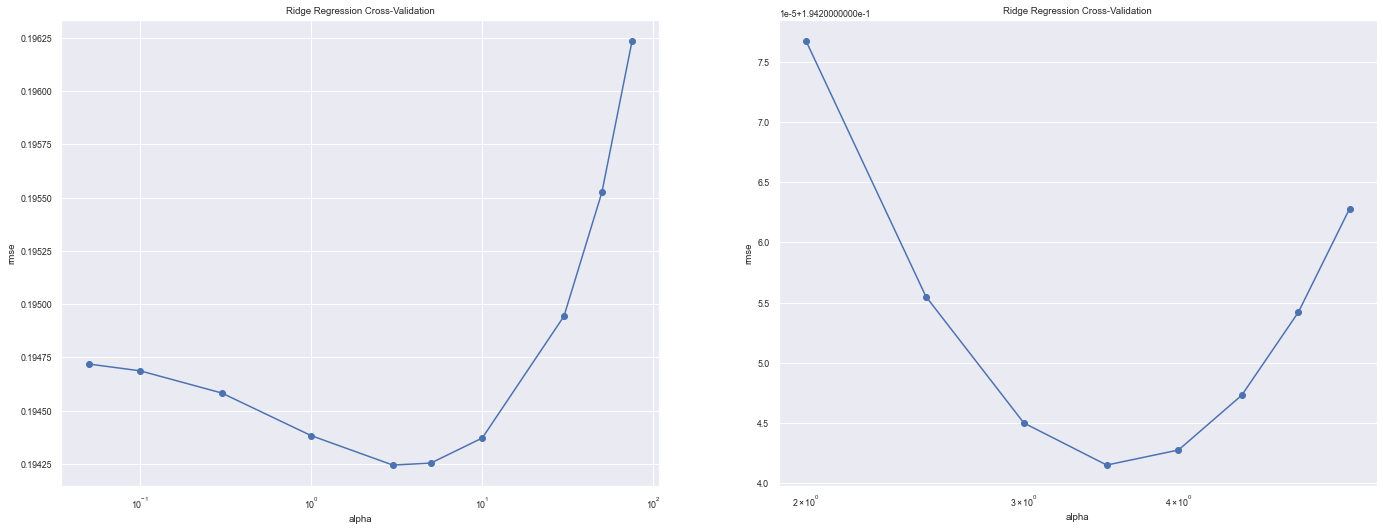

In [85]:
cv_ridge1 = pd.Series(cv_ridge1, index = alphas1)
cv_ridge2 = pd.Series(cv_ridge2, index = alphas2)

fig, axes = plt.subplots(1,2,figsize=(21,8))
cv_ridge1.plot(title = 'Ridge Regression Cross-Validation', style='-o', ax=axes[0])
axes[0].set_xlabel('alpha')
axes[0].set_ylabel('rmse')
axes[0].set_xscale('log')

cv_ridge2.plot(title = 'Ridge Regression Cross-Validation', style='-o', ax=axes[1])
axes[1].set_xlabel('alpha')
axes[1].set_ylabel('rmse')
axes[1].set_xscale('log')

In [86]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = alphas1,
        y = cv_ridge1,
        line = dict(color='royalBlue', width=2)
        ),
)

fig.update_layout(
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Penalty',
            font=dict(
                size=16
            )
        )
    ),
    
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='Cross-validation error',
            font=dict(
                size=16
            )
        )
    ),
)

fig.update_layout(height=400,
                 width=600,
                 title='Telescopic Search: Coarse level',
                     xaxis_type='log',
                     showlegend=False)
fig.show()

In [87]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = alphas2,
        y = cv_ridge2,
        line = dict(color='royalBlue', width=2)
        ),
)

fig.update_layout(
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Penalty',
            font=dict(
                size=16
            )
        )
    ),
    
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='Cross-validation error',
            font=dict(
                size=16
            )
        )
    ),
)

fig.update_layout(height=400,
                 width=600,
                 title='Telescopic Search: Coarse level',
                     xaxis_type='log',
                     showlegend=False)
fig.show()

### 2.2.1 Best Ridge Regression model

In [90]:
best_alpha = alphas2[np.argmin(cv_ridge2.values)] # 3.5
RR_CV_best = -rmse_cv(Ridge(alpha=best_alpha))
RR = Ridge(alpha=best_alpha)
RR.fit(X_train, y_train)
y_train_RR = RR.predict(X_train)
y_test_RR = RR.predict(X_test)
ridge_results = pd.DataFrame({'algorithm':['Ridge Regression'],
                             'CV error' : RR_CV_best.mean(),
                             'CV std': RR_CV_best.std(),
                             'training error': [mean_squared_error(y_train, y_train_RR)],
                             'test error': [mean_squared_error(y_test, y_test_RR)],
                             'training_r2_score': [r2_score(y_train, y_train_RR)],
                             'test_r2_score': [r2_score(y_test, y_test_RR)]})
ridge_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,Ridge Regression,0.194241,0.006121,0.191407,0.195105,0.583508,0.573302


In [91]:
y_test_RR

array([4.65170719, 4.07075136, 5.093173  , ..., 4.14213816, 4.00411129,
       4.33768856])